In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Import data 

In [14]:
data = pd.read_csv('../raw_data/fer2013.csv')

In [31]:
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

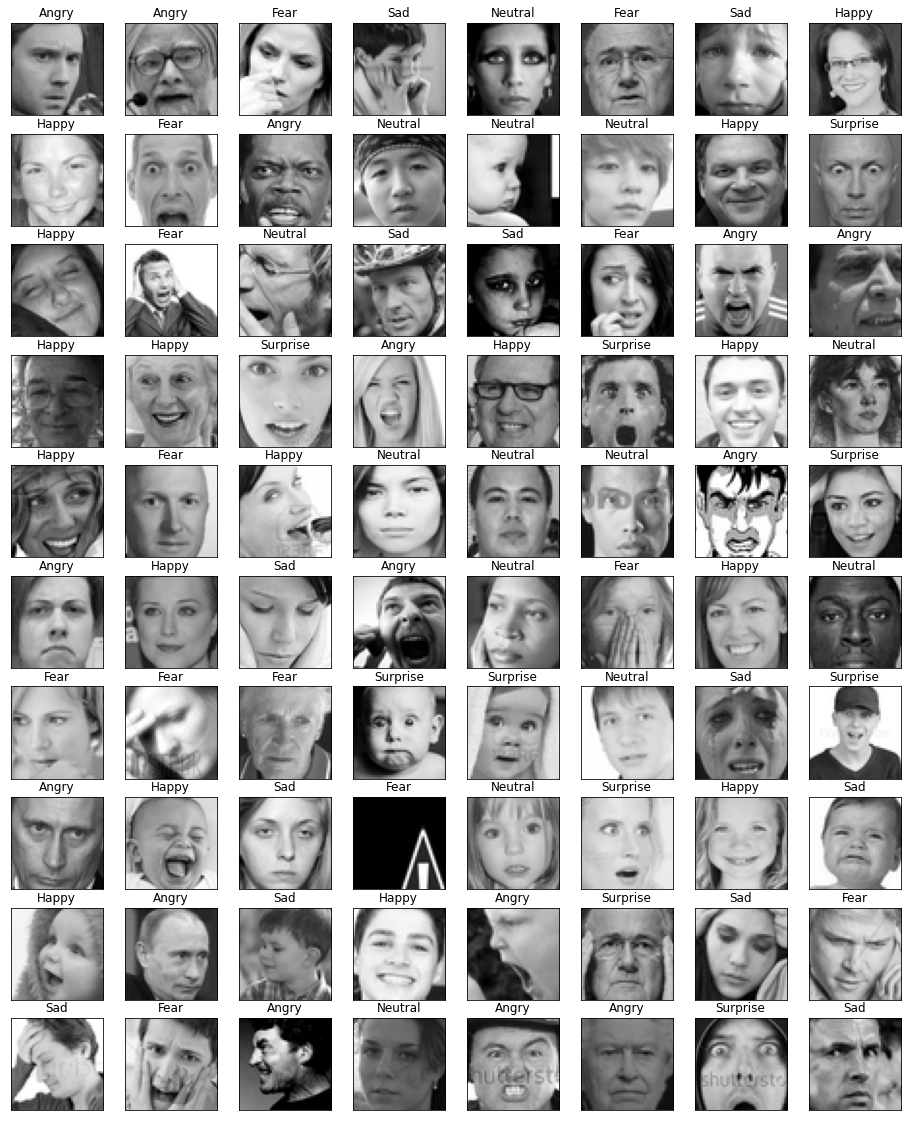

In [45]:
fig = plt.figure(figsize=(16,20))


for i in range(80):
    img = row2image(data.iloc[i])
    plt.subplot(10, 8, i + 1)
    plt.title(img[1], size=12)
    plt.imshow(img[0], cmap=plt.cm.gray)
    plt.xticks(())
    plt.yticks(());
